<a href="https://colab.research.google.com/github/MattBaudoin/SCMT610_GroupProject/blob/dev/Group_Project_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group 1

*   **Matthew Baudoin** - Setup environment, Stream raw dataset through cleanup job to Parquet, build Parquet chunk streaming utility
*  **Kevin Brown** - Explain reasoning behind pre-processing steps taken, difference between TF and TF-IDF Matrix
*   **Chelsea Jacobo** - Clean dataset
*   **Grace Morris** - Visualization insights into data
*   **Stephie Noel** - TF Matrix & TF-IDF Matrix
*   **Kal Zapotocky** - Visualize review length to star data relationship and make observations on review rating imbalance.







# NOTE: Our Kaggle dataset did not come with any source code, so everything was written from scratch.

# **Run Blocks 1-3 for Environment Setup**

In [ ]:
# 1 - Environment setup:

from google.colab import drive
drive.mount('/content/drive/')

In [23]:
# 2 - Environment setup: load dependencies & NLP Setup

from collections import Counter, defaultdict
from pathlib import Path
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import re
import string
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def ensure_nltk_resource(resource):
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(resource.split("/")[-1])

In [14]:
 # 3 - Configuration: Paths

BASE_DIR = Path.cwd()

RAW_DIR = BASE_DIR / "Yelp_Dataset"
RAW_REVIEW_FILE = "yelp_academic_dataset_review.json"
RAW_REVIEW_PATH = RAW_DIR / RAW_REVIEW_FILE

SLIM_PARQUET_DIR = BASE_DIR / "reviews_slim_parquet"
TEXT_CLEAN_CHUNK_DIR = BASE_DIR / "reviews_text_clean_parquet_chunks"

# validation and folder creation
assert RAW_REVIEW_PATH.exists(), f"Dataset not found: {RAW_REVIEW_PATH}"

SLIM_PARQUET_DIR.mkdir(parents=True, exist_ok=True)
TEXT_CLEAN_CHUNK_DIR.mkdir(parents=True, exist_ok=True)

print("Configuration validated")
print("RAW_REVIEW_PATH:", RAW_REVIEW_PATH)

Configuration validated
RAW_REVIEW_PATH: C:\Users\Matt\PycharmProjects\SCMT610_GroupProject\raw\yelp_academic_dataset_review.json


In [11]:
# 4 - NLTK resources + stopwords/lemmatizer

ensure_nltk_resource("corpora/stopwords")
ensure_nltk_resource("corpora/wordnet")
ensure_nltk_resource("corpora/omw-1.4")

stop_words = set(stopwords.words("english"))

# Keep negations (critical for sentiment / low-satisfaction language)
NEGATIONS = {"no", "not", "nor", "never", "n't"}
stop_words = stop_words - NEGATIONS

lemmatizer = WordNetLemmatizer()

print(f"Stopwords loaded: {len(stop_words)} (negations kept)")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...


Stopwords loaded: 195 (negations kept)


# **Blocks 5-7 dont need to be run again. This was only to inspect the original database**

In [15]:
# 5 - Exploratory Data Analysis: Sample the raw JSONL and inspect
# NOTE: Do NOT load the full ~5GB JSONL into memory in Colab.

# The following code is retained for reference, but is not executed.

# df_raw = pd.read_json(DATA_PATH, lines=True)

# Instead, Load a small sample of the JSON Lines file for exploratory analysis

SAMPLE_N = 10_000  # number of lines to sample

df_sample = pd.read_json(RAW_REVIEW_PATH, lines=True, nrows=SAMPLE_N)

# Quick inspection
display(df_sample.head())
print("\nShape:", df_sample.shape)
print("\nColumns:", df_sample.columns.tolist())

# Check missing values (top 15)
print("\nMissing values (top 15):")
print(df_sample.isna().sum().sort_values(ascending=False).head(15))

# Basic stats for star ratings if present
if "stars" in df_sample.columns:
    print("\nStars distribution:")
    print(df_sample["stars"].value_counts().sort_index())

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15



Shape: (10000, 9)

Columns: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

Missing values (top 15):
review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

Stars distribution:
stars
1    1079
2     763
3    1139
4    2574
5    4445
Name: count, dtype: int64


In [16]:
# 6 - Dataset dimensions and schema

df_sample.info()

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    10000 non-null  str           
 1   user_id      10000 non-null  str           
 2   business_id  10000 non-null  str           
 3   stars        10000 non-null  int64         
 4   useful       10000 non-null  int64         
 5   funny        10000 non-null  int64         
 6   cool         10000 non-null  int64         
 7   text         10000 non-null  str           
 8   date         10000 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(4), str(4)
memory usage: 6.6 MB


In [21]:
# 7 - Quick text sanity checks

df_sample["text_len_chars"] = df_sample["text"].str.len()
df_sample["text_len_words"] = df_sample["text"].str.split().str.len()

print("Avg chars:", df_sample["text_len_chars"].mean())
print("Avg words:", df_sample["text_len_words"].mean())
print("\nWord length percentiles:")
print(df_sample["text_len_words"].quantile([0.5, 0.9, 0.95, 0.99]))

print("\nExamples of short reviews:")
display(df_sample.loc[df_sample["text_len_words"] <= 5, ["stars", "text"]].head(10))

print("\nExamples of long reviews:")
display(df_sample.sort_values("text_len_words", ascending=False)[["stars","text"]].head(3))

Avg chars: 549.0391
Avg words: 101.2285

Word length percentiles:
0.50     73.0
0.90    208.0
0.95    277.0
0.99    467.0
Name: text_len_words, dtype: float64

Examples of short reviews:


,stars,text
9160,4,They have good nonpariel cookies.



Examples of long reviews:


,stars,text
695,1,"Unfortunately, I'm NOT happy after coming to t..."
9269,5,So I have this problem in life. For whatever ...
8165,3,I purchased a Groupon for a night stay here in...


Total rows written: 6990280


In [18]:
# 8 - One time Dataset construction retaining columns required for analysis: JSONL to Parquet
# Useful columns are: review_id, business_id, stars, text, date
#
# NOTE: Tried using CSV for the slimmed dataset, however it is still too large to load into Colabs memory.
# After research, parquet is the better file format, especially for large datasets for ML/Analytics pipelines


existing_parts = glob.glob(os.path.join(SLIM_PARQUET_DIR, "part_*.parquet"))
if existing_parts:
    print(f"Slim parquet already exists ({len(existing_parts)} files). Skipping rebuild.")
else:
    os.makedirs(SLIM_PARQUET_DIR, exist_ok=True)

# Record start time to measure end-to-end write performance
    start_time = time.time()
    n_parts = 0

# Stream the large JSON Lines file in blocks to avoid memory issues
# Each iteration writes one self-contained Parquet partition;
# the full dataset is represented by the collection of part files
    for df_block in pd.read_json(
        RAW_REVIEW_PATH,
        lines=True,
        chunksize=100_000
    ):
        df_block = df_block[["review_id", "business_id", "stars", "text", "date"]]

    # Construct a unique filename for this block to create a partitioned dataset
        part_path = os.path.join(SLIM_PARQUET_DIR, f"part_{n_parts:05d}.parquet")

    # Write the current block to disk as a compressed Parquet file
        df_block.to_parquet(
            part_path,
            compression="snappy",
            index=False,
            engine="pyarrow"
        )

    # Increment part counter for the next block
        n_parts += 1

    elapsed = time.time() - start_time
    print(f"Reduced dataset written to: {SLIM_PARQUET_DIR}")
    print(f"Parquet files written: {n_parts}")
    print(f"Time elapsed: {elapsed / 60:.1f} minutes")

Reduced dataset written to: C:\Users\Matt\PycharmProjects\SCMT610_GroupProject\reviews_slim_parquet
Parquet files written: 70
Time elapsed: 1.5 minutes


In [22]:
# 9 - Post slimming sanity checks
parts = sorted(glob.glob(os.path.join(SLIM_PARQUET_DIR, "part_*.parquet")))
print("Parts found:", len(parts))
print("First part:", parts[0])

df_check = pd.read_parquet(parts[0], engine="pyarrow")

print("Shape:", df_check.shape)
print("Columns:", df_check.columns.tolist())
print("\nDtypes:\n", df_check.dtypes)

print("\nNulls:\n", df_check.isna().sum())

print("\nStars distribution (first part):")
print(df_check["stars"].value_counts().sort_index())

print("\nSample text:")
print(df_check.loc[0, "text"][:300])

total_rows = 0
for f in glob.glob(os.path.join(SLIM_PARQUET_DIR, "part_*.parquet")):
    total_rows += pq.ParquetFile(f).metadata.num_rows
print("Total rows written:", total_rows)

Parts found: 70
First part: C:\Users\Matt\PycharmProjects\SCMT610_GroupProject\reviews_slim_parquet\part_00000.parquet
Shape: (100000, 5)
Columns: ['review_id', 'business_id', 'stars', 'text', 'date']

Dtypes:
 review_id                 str
business_id               str
stars                   int64
text                      str
date           datetime64[us]
dtype: object

Nulls:
 review_id      0
business_id    0
stars          0
text           0
date           0
dtype: int64

Stars distribution (first part):
stars
1    10921
2     7988
3    11362
4    25337
5    44392
Name: count, dtype: int64

Sample text:
If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. 

The food is good, but it takes a very long time to come out. The w
Total rows written: 6990280


# You only NEED to run steps 10-11 assuming you intend to re-clean the dataset

# If this isnt you, skip to step 12

In [25]:
#10 - Basic quality cleanup and text cleaning functions

# Precompile regex once (faster)
RE_URL_EMAIL = re.compile(r"http\S+|www\.\S+|\S+@\S+")
RE_NBSP_HTML = re.compile(r"&nbsp;")
RE_WS = re.compile(r"\s+")
RE_ELONG = re.compile(r"(.)\1{2,}")          # soooo -> soo
RE_NUM = re.compile(r"\d+")
RE_PUNCT_KEEP_HYPHEN = re.compile(r"[^\w\s\-]")  # remove punctuation but keep hyphen
RE_APOSTROPHE = re.compile(r"[’`´]")         # normalize weird apostrophes to '

# Contractions (simple, good-enough starter list)
CONTRACTIONS = {
    "can't": "can not",
    "won't": "will not",
    "n't": " not",
    "i'm": "i am",
    "it's": "it is",
    "that's": "that is",
    "what's": "what is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "mustn't": "must not",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "i've": "i have",
    "we've": "we have",
    "they've": "they have",
    "i'll": "i will",
    "we'll": "we will",
    "they'll": "they will",
    "she's": "she is",
    "he's": "he is",

}
# Build a regex that matches keys like "can't", "won't", etc.
RE_CONTRACTIONS = re.compile(r"\b(" + "|".join(map(re.escape, CONTRACTIONS.keys())) + r")\b")

def expand_contractions(text: str) -> str:
    # normalize apostrophes first
    text = RE_APOSTROPHE.sub("'", text)
    return RE_CONTRACTIONS.sub(lambda m: CONTRACTIONS[m.group(0)], text)

def reduce_character_noise(token: str) -> str:
    return RE_ELONG.sub(r"\1\1", token)

def clean_review_text_method(text: str) -> str:
    # 1) Ensure string + Unicode normalize (keeps accents but normalizes representation)
    text = "" if text is None else str(text)
    text = unicodedata.normalize("NFKC", text)

    # 2) Normalize NBSP and whitespace-ish artifacts
    text = text.replace("\u00A0", " ")      # actual NBSP char
    text = RE_NBSP_HTML.sub(" ", text)      # literal &nbsp; if present

    # 3) Lowercase
    text = text.lower()

    # 4) Remove URLs/emails
    text = RE_URL_EMAIL.sub(" ", text)

    # 5) Expand contractions BEFORE tokenization
    text = expand_contractions(text)

    # 6) Normalize numbers to a token
    text = RE_NUM.sub(" num_token ", text)

    # 7) Punctuation policy:
    #    - remove punctuation except hyphens
    #    - then split hyphens to spaces (wait-time -> wait time)
    text = RE_PUNCT_KEEP_HYPHEN.sub(" ", text)
    text = text.replace("-", " ")

    # 8) Collapse whitespace
    text = RE_WS.sub(" ", text).strip()

    # 9) Tokenize
    tokens = text.split()

    cleaned_tokens = []
    for tok in tokens:
        tok = reduce_character_noise(tok)

        # keep num_token as-is
        if tok == "num_token":
            cleaned_tokens.append(tok)
            continue

        # keep alphabetic tokens that aren't stopwords (negations already preserved in stop_words)
        if tok.isalpha() and tok not in stop_words:
            tok = lemmatizer.lemmatize(tok)
            cleaned_tokens.append(tok)

    return " ".join(cleaned_tokens)

In [26]:
#11 - Apply cleaning method in manageable chunks
# Output: one cleaned chunk per slim parquet part

LOG_EVERY = 5          # log every N parts
MIN_WORDS = 5          # your post-cleaning minimum (we can tune later)

part_files = sorted(glob.glob(os.path.join(SLIM_PARQUET_DIR, "part_*.parquet")))
total_parts = len(part_files)

# Resume: detect already-written chunks
existing_files = glob.glob(os.path.join(TEXT_CLEAN_CHUNK_DIR, "chunk_*.parquet"))
print(f"Total parts to process: {total_parts}")
print(f"Chunks already on disk: {len(existing_files)}")

t0 = time.time()
processed = 0
skipped = 0

for part_idx, part_path in enumerate(part_files):
    chunk_path = os.path.join(TEXT_CLEAN_CHUNK_DIR, f"chunk_{part_idx:05d}.parquet")

    # Resume: skip completed
    if os.path.exists(chunk_path):
        skipped += 1
        continue

    df = pd.read_parquet(part_path, engine="pyarrow")

    # Basic cleanup (per part)
    df["text"] = df["text"].astype("string")
    df = df.dropna(subset=["text"])
    df = df[df["text"].str.strip() != ""]
    df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)  # within-part dedupe

    # Apply cleaning
    df["text_clean"] = df["text"].map(clean_review_text_method)

    # Drop empty after cleaning
    df = df[df["text_clean"].str.strip() != ""]

    # Min word filter (vectorized)
    df["clean_word_count"] = df["text_clean"].str.split().str.len()
    df = df[df["clean_word_count"] >= MIN_WORDS]

    # Keep only needed columns (drop raw text)
    df = df[["review_id", "business_id", "stars", "date", "text_clean"]].reset_index(drop=True)

    # Write checkpoint
    tmp_path = chunk_path + ".tmp"
    df.to_parquet(tmp_path, index=False, compression="snappy", engine="pyarrow")
    os.replace(tmp_path, chunk_path)  # atomic on Windows

    processed += 1

    if processed % LOG_EVERY == 0:
        elapsed = time.time() - t0
        done = part_idx + 1
        pct = 100 * done / total_parts
        rate = done / elapsed if elapsed > 0 else 0
        eta_min = (total_parts - done) / rate / 60 if rate > 0 else float("inf")
        print(f"[{done:>3}/{total_parts}] {pct:>6.2f}% | elapsed {elapsed/60:>6.1f}m | ETA {eta_min:>6.1f}m | wrote {len(df):,} rows")

elapsed = time.time() - t0
print(f"Cleaning complete. processed={processed}, skipped={skipped}, elapsed={elapsed/60:.1f} min")
print("Output:", TEXT_CLEAN_CHUNK_DIR)

Total parts to process: 70
Chunks already on disk: 0
[  5/70]   7.14% | elapsed    3.2m | ETA   41.2m | wrote 99,919 rows
[ 10/70]  14.29% | elapsed    6.9m | ETA   41.2m | wrote 99,928 rows
[ 15/70]  21.43% | elapsed   10.4m | ETA   38.2m | wrote 99,928 rows
[ 20/70]  28.57% | elapsed   13.8m | ETA   34.5m | wrote 99,913 rows
[ 25/70]  35.71% | elapsed   17.3m | ETA   31.1m | wrote 99,915 rows
[ 30/70]  42.86% | elapsed   20.8m | ETA   27.7m | wrote 99,912 rows
[ 35/70]  50.00% | elapsed   24.9m | ETA   24.9m | wrote 99,924 rows
[ 40/70]  57.14% | elapsed   28.5m | ETA   21.4m | wrote 99,849 rows
[ 45/70]  64.29% | elapsed   31.7m | ETA   17.6m | wrote 99,908 rows
[ 50/70]  71.43% | elapsed   35.1m | ETA   14.0m | wrote 99,908 rows
[ 55/70]  78.57% | elapsed   39.2m | ETA   10.7m | wrote 99,911 rows
[ 60/70]  85.71% | elapsed   43.1m | ETA    7.2m | wrote 99,881 rows
[ 65/70]  92.86% | elapsed   48.6m | ETA    3.7m | wrote 99,894 rows
[ 70/70] 100.00% | elapsed   52.7m | ETA    0.0m |

In [27]:
# 12 - Checking the file size of our cleaned database

files = glob.glob(os.path.join(TEXT_CLEAN_CHUNK_DIR, "chunk_*.parquet"))
print("Chunk files:", len(files))

if not files:
    print("No chunk files found yet.")
else:
    total_bytes = sum(os.path.getsize(f) for f in files)
    print("Total size (GB):", total_bytes / (1024**3))
    print("Smallest file (MB):", min(os.path.getsize(f) for f in files) / (1024**2))
    print("Largest file (MB):", max(os.path.getsize(f) for f in files) / (1024**2))

Chunk files: 70
Total size (GB): 1.6203952506184578
Smallest file (MB): 22.7324275970459
Largest file (MB): 25.91992950439453


In [28]:
# 13 - Post-cleaning validation: confirm cleaned chunk outputs are complete and sane
# - Counts cleaned chunk files and total disk usage
# - Samples a few chunks to verify schema, nulls, stars distribution, text lengths
# - Verifies key cleaning policies (num_token presence, negations retained)
chunk_files = sorted(glob.glob(os.path.join(TEXT_CLEAN_CHUNK_DIR, "chunk_*.parquet")))
print("Cleaned chunks found:", len(chunk_files))
assert len(chunk_files) > 0, "No cleaned chunks found."

# Load a few chunks (first, middle, last) for quick checks
sample_idxs = [0, len(chunk_files)//2, len(chunk_files)-1]
dfs = []
for idx in sample_idxs:
    df = pd.read_parquet(chunk_files[idx], engine="pyarrow")
    df["chunk_id"] = idx
    dfs.append(df)

df_check = pd.concat(dfs, ignore_index=True)

print("\nColumns:", df_check.columns.tolist())
print("\nDtypes:\n", df_check.dtypes)

# Basic sanity
print("\nRows sampled:", len(df_check))
print("Nulls:\n", df_check.isna().sum())

# Stars distribution (in sampled chunks)
print("\nStars distribution (sampled chunks):")
print(df_check["stars"].value_counts().sort_index())

# Text length distribution
df_check["clean_words"] = df_check["text_clean"].str.split().str.len()
print("\nClean word count percentiles:")
print(df_check["clean_words"].quantile([0.1, 0.5, 0.9, 0.95, 0.99]))

# Verify policy effects
print("\nnum_token frequency (docs containing it):",
      (df_check["text_clean"].str.contains(r"\bnum_token\b")).mean())

negation_terms = ["not", "no", "never"]
for term in negation_terms:
    frac = (df_check["text_clean"].str.contains(rf"\b{term}\b")).mean()
    print(f"Docs containing '{term}': {frac:.3f}")

# Quick samples
print("\nSample cleaned texts:")
display(df_check[["stars","text_clean"]].head(10))

Cleaned chunks found: 70

Columns: ['review_id', 'business_id', 'stars', 'date', 'text_clean', 'chunk_id']

Dtypes:
 review_id                 str
business_id               str
stars                   int64
date           datetime64[us]
text_clean                str
chunk_id                int64
dtype: object

Rows sampled: 290051
Nulls:
 review_id      0
business_id    0
stars          0
date           0
text_clean     0
chunk_id       0
dtype: int64

Stars distribution (sampled chunks):
stars
1     41798
2     22714
3     29837
4     64046
5    131656
Name: count, dtype: int64

Clean word count percentiles:
0.10     15.0
0.50     40.0
0.90    113.0
0.95    149.0
0.99    248.0
Name: clean_words, dtype: float64

num_token frequency (docs containing it): 0.403298040689396
Docs containing 'not': 0.576
Docs containing 'no': 0.161
Docs containing 'never': 0.115

Sample cleaned texts:


,stars,text_clean
0,3,decide eat aware going take num_token hour beg...
1,5,taken lot spin class year nothing compare clas...
2,3,family diner buffet eclectic assortment large ...
3,5,wow yummy different delicious favorite lamb cu...
4,4,cute interior owner gave u tour upcoming patio...
5,1,long term frequent customer establishment went...
6,5,loved tour grabbed groupon price great perfect...
7,5,amazingly amazing wing homemade bleu cheese ri...
8,3,easter instead going lopez lake went los padre...
9,3,party num_token hibachi waitress brought separ...


# **Run step 14 next, it defines utilities and helpers that will assist with analyzing the cleaned dataset**

In [30]:
# 14 - Define helpers and utilities

def iter_parquet_chunks(parquet_dir, pattern="chunk_*.parquet", columns=None, engine="pyarrow"):
    parquet_dir = str(parquet_dir)  # allow Path objects
    files = sorted(glob.glob(str(Path(parquet_dir) / pattern)))
    if not files:
        raise FileNotFoundError(f"No parquet files found in {parquet_dir} matching {pattern}")

    for f in files:
        yield f, pd.read_parquet(f, columns=columns, engine=engine)

**From here on we will be performing dataset analysis. As the dataset remains large (~1.6GB), we will use the above utility to stream the dataset from TEXT_CLEAN_CHUNK_DIR through any analysis steps.**

In [31]:
# 15 - Count the distribution of star ratings

star_counts = Counter()

for _, df_part in iter_parquet_chunks(
    TEXT_CLEAN_CHUNK_DIR,
    columns=["stars"]
):
    star_counts += Counter(df_part["stars"].value_counts().to_dict())

print(star_counts)

Counter({5: 3228404, 4: 1451563, 1: 1068541, 3: 691362, 2: 543848})


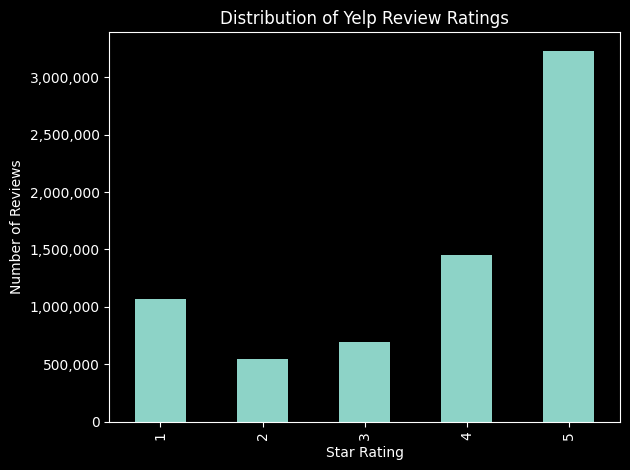

In [32]:
# 16 - Show star rating distribution as a graph

star_series = (
    pd.Series(star_counts)
    .sort_index()
)

star_series.plot(kind="bar")
plt.title("Distribution of Yelp Review Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")

# Format y-axis with commas
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{int(x):,}")
)

plt.tight_layout()
plt.show()

### Insight 1: Yelp Reviews Are Positively Skewed

The distribution of Yelp star ratings shows a strong skew toward higher ratings,
with the majority of reviews being 4 or 5 stars. This suggests that Yelp users
are more likely to leave reviews after positive experiences, which may introduce
a positivity bias in sentiment-based analyses. You can also see that there is more 1 star reviews than 2 & 3. This shows that people are likely more motivated to leave a review if they have an exceptionally good experience (4/5 stars) or an exceptionally poor experience (1 star)

In [33]:
# 17 - Count review lengths

cap = 300
bins = 50
bin_edges = np.linspace(0, cap, bins + 1)   # 51 edges define 50 bins
hist_counts = np.zeros(bins, dtype=np.int64)

total_reviews = 0

for _, df_part in iter_parquet_chunks(
    TEXT_CLEAN_CHUNK_DIR,
    columns=["text_clean"]
):
    # word counts for this chunk
    lengths = df_part["text_clean"].str.split().str.len().astype(np.int32)

    # cap long reviews
    lengths = lengths.clip(upper=cap).to_numpy()

    # update histogram counts
    counts, _ = np.histogram(lengths, bins=bin_edges)
    hist_counts += counts
    total_reviews += len(lengths)

print("Total reviews processed:", total_reviews)


Total reviews processed: 6983718


In [35]:
# 18 - Summarize review lengths

cum = np.cumsum(hist_counts)
n = cum[-1]

def approx_percentile(p):
    target = p * n
    idx = np.searchsorted(cum, target)
    idx = min(idx, len(hist_counts) - 1)
    return float((bin_edges[idx] + bin_edges[idx + 1]) / 2)

summary = {
    "Total reviews processed": f"{n:,}",
    "Median review length (50th percentile)": approx_percentile(0.50),
    "90th percentile review length": approx_percentile(0.90),
    "95th percentile review length": approx_percentile(0.95),
    "99th percentile review length": approx_percentile(0.99),
    f"Reviews at max cap ({cap} words)": int(hist_counts[-1]),
}

for k, v in summary.items():
    print(f"{k}: {v}")

Total reviews processed: 6,983,718
Median review length (50th percentile): 39.0
90th percentile review length: 111.0
95th percentile review length: 147.0
99th percentile review length: 249.0
Reviews at max cap (300 words): 39604


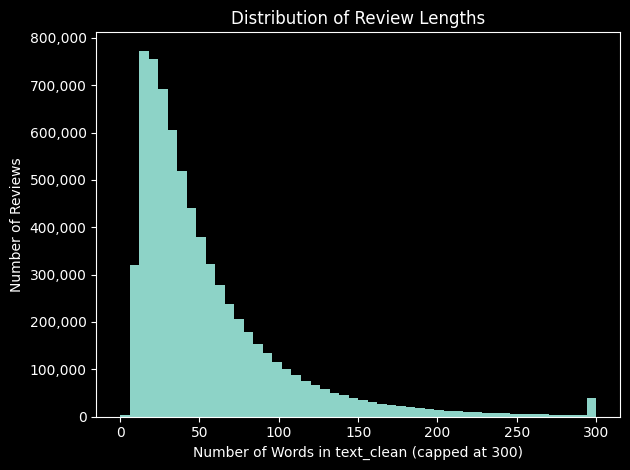

In [36]:
# 19 - Visualize review length with a histogram

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bar_width = bin_edges[1] - bin_edges[0]

plt.bar(bin_centers, hist_counts, width=bar_width, align="center")

plt.title("Distribution of Review Lengths")
plt.xlabel(f"Number of Words in text_clean (capped at {cap})")
plt.ylabel("Number of Reviews")

plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{int(x):,}")
)

plt.tight_layout()
plt.show()

### Insight 2: Review Lengths Are Right-Skewed

The distribution of review lengths shows a strong right skew, with most Yelp
reviews containing fewer than 100 words. A smaller number of reviews are much
longer, forming a long tail. This indicates that while most users leave brief
feedback, a subset of users provide detailed reviews that may contain richer
context and sentiment for text analysis.


In [38]:
# 20 - Analyze relationship between review length and star rating (histogram-based)

MAX_WORDS = 300

# counts_by_star[star][k] = how many reviews of this star have length k (capped)
counts_by_star = {star: np.zeros(MAX_WORDS + 1, dtype=np.int64) for star in [1, 2, 3, 4, 5]}

for _, df_part in iter_parquet_chunks(
    TEXT_CLEAN_CHUNK_DIR,
    columns=["stars", "text_clean"]
):
    lengths = (
        df_part["text_clean"]
        .str.split()
        .str.len()
        .clip(upper=MAX_WORDS)
        .to_numpy()
    )
    stars = df_part["stars"].to_numpy()

    for star in [1, 2, 3, 4, 5]:
        star_lengths = lengths[stars == star]
        if star_lengths.size:
            counts_by_star[star] += np.bincount(star_lengths, minlength=MAX_WORDS + 1)

In [39]:
# 21 - Calculate median review length per star from histogram counts

def median_from_counts(counts: np.ndarray) -> int:
    cum = np.cumsum(counts)
    n = cum[-1]
    if n == 0:
        return 0
    target = (n - 1) // 2  # 0-index median position
    return int(np.searchsorted(cum, target))

star_levels = [1, 2, 3, 4, 5]
median_lengths = [median_from_counts(counts_by_star[s]) for s in star_levels]

print(dict(zip(star_levels, median_lengths)))

{1: 50, 2: 53, 3: 49, 4: 43, 5: 32}


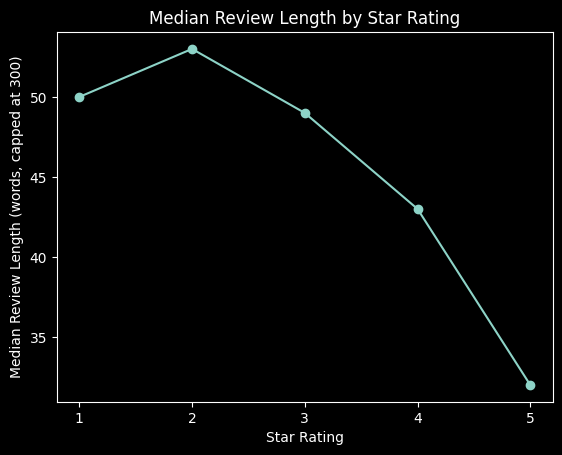

In [40]:
# 22 Visualize Median Review Length by Star Rating

plt.figure()
plt.plot(star_levels, median_lengths, marker="o")
plt.xlabel("Star Rating")
plt.ylabel("Median Review Length (words, capped at 300)")
plt.title("Median Review Length by Star Rating")
plt.xticks(star_levels)
plt.show()

### Insight:

Low rated reviews have a tendancy to be longer than higher star ratings, suggesting that dissatisfied customers are more likely to provided detailed written feedback.

In [42]:
# 23 - Star Rating Distribution and Class Balance
# For predicting dissatisfaction, we should reframe star ratings as a binary
# 1-2 Stars is Low satisfaction
# 3-5 Stars is Not low satisfaction

assert sum(star_counts.values()) > 1_000_000, "star_counts looks too small—did you compute it on full data?"

low_satisfaction = star_counts.get(1, 0) + star_counts.get(2, 0)
not_low_satisfaction = (
    star_counts.get(3, 0)
    + star_counts.get(4, 0)
    + star_counts.get(5, 0)
)

total_reviews = low_satisfaction + not_low_satisfaction
if total_reviews == 0:
    raise ValueError("total_reviews is 0; star_counts is empty.")

print(f"Low satisfaction (1–2 stars): {low_satisfaction:,} "
      f"({100 * low_satisfaction / total_reviews:.1f}%)")

print(f"Not low satisfaction (3–5 stars): {not_low_satisfaction:,} "
      f"({100 * not_low_satisfaction / total_reviews:.1f}%)")

Low satisfaction (1–2 stars): 1,612,389 (23.1%)
Not low satisfaction (3–5 stars): 5,371,329 (76.9%)


### Insight

After dividing star ratings into two classes, low satisfaction (1–2 stars) and not low satisfaction (3–5 stars), it is clear that low satisfaction reviews represent the minority class. While a future model could achieve high accuracy by predicting “not low satisfaction” for most reviews, accurately identifying dissatisfied customers will require focusing on language patterns that are specifically associated with negative reviews.

# **Creating TF Matrix by creating corpus, converting data, etc.**

In [43]:
# 24 - Build sample corpus for TF / TF-IDF

# ML algorithms require numerical input, not raw text.
# The TF matrix converts each review into a vector of word counts, enabling:
#   * Classification models (sentiment prediction)
#   * Clustering algorithms (topic discovery)
#   * Similarity computations (finding related reviews)

MAX_DOCS  = 200_000   # cap to control RAM
MAX_WORDS = 300       # truncate long reviews based on prior EDA

corpus = []          # list of cleaned review texts (documents)
star_ratings = []    # corresponding star ratings

for _, df_part in iter_parquet_chunks(TEXT_CLEAN_CHUNK_DIR, columns=["stars", "text_clean"]):
    remaining = MAX_DOCS - len(corpus)
    if remaining <= 0:
        break

    df_part = df_part.head(remaining)

    texts = (
        df_part["text_clean"]
        .str.split()
        .str[:MAX_WORDS]
        .str.join(" ")
    )

    corpus.extend(texts.tolist())
    star_ratings.extend(df_part["stars"].tolist())

print(f"Sample corpus size: {len(corpus):,} reviews")

Sample corpus size: 200,000 reviews


In [50]:
# 25 - Build Term Frequency (TF) matrix
# Tokenization: Splits text into individual words (tokens)
# Vocabulary building: Creates a dictionary of all unique words
# Counting: For each document, counts occurrences of each vocabulary word
# Initialize CountVectorizer to create the TF matrix

tf_vectorizer = CountVectorizer(
    max_features=50_000,  # limit vocabulary size for stability
    min_df=10,     # ignore terms that appear in <10 docs
    max_df=0.9    # ignore terms that appear in >90% of docs
)

# The output is stored as a sparse matrix because:
#   * Most entries are zero (a review uses only ~50 of 24,232 vocabulary words)
#   * Sparse format stores only non-zero values, saving ~99% memory
#   * Scikit-learn algorithms are optimized for sparse input
# Fit and transform the corpus to get the TF matrix
tf_matrix = tf_vectorizer.fit_transform(corpus)

print("TF matrix shape:", tf_matrix.shape)

TF matrix shape: (200000, 18738)


In [51]:
#26 - Build TF - IDF Matrix
# LIMITATION OF RAW TF: Simple word counts treat all words equally, but some
#   words are more informative than others. "Delicious" appearing in a food
#   review is more meaningful than "food" which appears in most reviews.

# Initialize TfidfVectorizer to create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    vocabulary=tf_vectorizer.vocabulary_,
     sublinear_tf=True
)

# Fit and transform the corpus to get the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (200000, 18738)


# **Vocabulary Inspection**

In [52]:
#27 - Attempting to get a view of the TF Matrix results
# VOCABULARY INSPECTION: Viewing feature names reveals:
#   * Tokenization behavior (how words are split and normalized)
#   * Presence of unexpected tokens (numbers, artifacts)
#   * Vocabulary size and composition

# 27 - Inspect TF vocabulary + first document TF counts


tf_feature_names = tf_vectorizer.get_feature_names_out()
print(f"Total TF features: {len(tf_feature_names)}")

# A) One review: top TF counts
doc_idx = 0
first_review_tf = tf_matrix[doc_idx]
nonzero_indices = first_review_tf.nonzero()[1]

pairs = [(tf_feature_names[i], int(first_review_tf[0, i])) for i in nonzero_indices]
pairs.sort(key=lambda x: x[1], reverse=True)

print(f"\nTop TF counts for review #{doc_idx}:")
for term, cnt in pairs[:25]:
    print(f"  {term}: {cnt}")

# B) Whole corpus: top TF terms
term_counts = np.asarray(tf_matrix.sum(axis=0)).ravel()
top_idx = term_counts.argsort()[::-1][:25]

print("\nTop 25 terms by total TF count in corpus:")
for i in top_idx:
    print(f"  {tf_feature_names[i]}: {int(term_counts[i]):,}")

Total TF features: 18738

Top TF counts for review #0:
  take: 2
  time: 2
  experience: 2
  long: 2
  usually: 2
  decide: 1
  eat: 1
  aware: 1
  going: 1
  num_token: 1
  hour: 1
  beginning: 1
  end: 1
  tried: 1
  multiple: 1
  want: 1
  like: 1
  location: 1
  nj: 1
  never: 1
  bad: 1
  food: 1
  good: 1
  come: 1
  waitstaff: 1

Top 25 terms by total TF count in corpus:
  not: 250,962
  num_token: 202,847
  food: 111,752
  place: 108,697
  good: 103,641
  great: 94,325
  time: 75,732
  service: 66,514
  like: 63,527
  one: 61,994
  get: 61,992
  would: 58,422
  back: 54,757
  go: 54,562
  really: 48,683
  also: 42,165
  no: 39,951
  nice: 37,480
  restaurant: 36,729
  got: 36,415
  best: 36,061
  well: 33,957
  order: 33,186
  could: 32,859
  staff: 32,740


In [53]:
# 28 - Inspect TF-IDF weights for the same review

doc_idx = 0  # keep consistent with Cell 27

first_review_tfidf = tfidf_matrix[doc_idx]
nonzero_indices = first_review_tfidf.nonzero()[1]

# Sort by highest TF-IDF weight
pairs = [(tf_feature_names[i], float(first_review_tfidf[0, i])) for i in nonzero_indices]
pairs.sort(key=lambda x: x[1], reverse=True)

print(f"Top TF-IDF weights for review #{doc_idx}:")
for term, w in pairs[:25]:
    print(f"  {term}: {w:.4f}")

Top TF-IDF weights for review #0:
  quicker: 0.2569
  opt: 0.2550
  usually: 0.2411
  nj: 0.2398
  aware: 0.2183
  beginning: 0.2163
  waitstaff: 0.2155
  long: 0.2085
  decide: 0.2004
  take: 0.1901
  multiple: 0.1843
  young: 0.1828
  experience: 0.1801
  diner: 0.1796
  spent: 0.1772
  pleasant: 0.1632
  weekend: 0.1515
  waiting: 0.1464
  end: 0.1453
  done: 0.1383
  time: 0.1281
  tried: 0.1237
  bad: 0.1228
  another: 0.1227
  location: 0.1215


The difference between a TF Matrix and TF-IDF Matrix:


*   A TF Matrix counts how many times each word appears in each document
*   A TF-IDF Matrix weights each word by how distinctive it is across the entire corpus





In [49]:
term = "opt"
idx = tf_vectorizer.vocabulary_.get(term)
if idx is None:
    print("Term not in vocabulary:", term)
else:
    df_count = (tf_matrix[:, idx] > 0).sum()
    total_docs = tf_matrix.shape[0]
    print(f"Docs containing '{term}': {int(df_count):,} / {total_docs:,} ({100*df_count/total_docs:.3f}%)")

Docs containing 'opt': 226 / 200,000 (0.113%)


In [54]:
term = "opt"
examples = []

for i, txt in enumerate(corpus):
    if " opt " in f" {txt} ":
        examples.append((i, star_ratings[i], txt))
    if len(examples) >= 10:
        break

for i, stars, txt in examples:
    print(f"\nDoc #{i} | stars={stars}\n{txt[:500]}")


Doc #0 | stars=3
decide eat aware going take num_token hour beginning end tried multiple time want like location nj never bad experience food good take long time come waitstaff young usually pleasant many experience spent way long waiting usually opt another diner restaurant weekend order done quicker

Doc #1028 | stars=4
ton good sushi place reno tried always seems like rickshaw freshest fish not big fan roll sauce opt mainly nigiri sashimi get dressed roll anywhere hell buy store true fan sushi fish rickshaw freshest town

Doc #3595 | stars=4
trying place answer typically wait til hangry opt frequent someplace known quickly satiate hunger cocktail really impressed fancy margarita sound simple dumb nope delicious different not think name would impressed not vegetarian option listed waitress let know could make almost anything meatless score truly enjoyed dinner corn cake veggie annd guacamole app tres lech cake fantastic well ambiance nice totally recommend someone looking date night